# Tech Stocks Time Series M/L Model using TensorFlow
### by Lim Jia Xiang

#### Import required libraries

In [1]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from math import sqrt

import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
google = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\google.csv')
sony = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\sony.csv')
tesla = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\tesla.csv')
alibaba = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\alibaba.csv')
apple = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\apple.csv')
baidu = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\baidu.csv')
microsoft = pd.read_csv(r'C:\Users\lim_j\Google Drive\Education\University (BZA)\Y2S1\BT2101\Assignment\HW6\Datasets\microsoft.csv')

In [3]:
closing_data = pd.DataFrame()

closing_data['google_close'] = google['Close']
#closing_data['sony_close'] = sony['Close']
#closing_data['tesla_close'] = tesla['Close']
#closing_data['alibaba_close'] = alibaba['Close']
#closing_data['apple_close'] = apple['Close']
#closing_data['baidu_close'] = baidu['Close']
#closing_data['microsoft_close'] = microsoft['Close']

closing_data = closing_data.fillna(method='ffill')

closing_data=closing_data.sort_index(axis=0,level=None,ascending=True)

In [4]:
closing_data.head()

,google_close
0,594.890015
1,594.969971
2,608.419983
3,611.289978
4,626.909973


In [5]:
closing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 1 columns):
google_close    511 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = closing_data.values
values = values.astype('float32')

# normalize features
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)

# frame as supervised learning
#reframed = series_to_supervised(scaled, 3, 1)

#reframed.drop(reframed.columns[-6:], axis=1, inplace=True)

#print(reframed.head())

# frame as supervised learning
reframed = series_to_supervised(values, 7, 1)
reframed.drop(reframed.columns[-1:], axis=1, inplace=True)

# normalise features by transforming values using MinMaxScaler so that all values are between 0 and 1 inclusive
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = pd.DataFrame(scaler.fit_transform(reframed.values))

print(scaled.head())

          0         1         2         3         4         5         6
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.006705  0.018228
1  0.000206  0.034602  0.007648  0.041945  0.040811  0.018228  0.009288
2  0.034800  0.041985  0.049272  0.081044  0.051938  0.009288  0.000000
3  0.042182  0.082169  0.088072  0.091705  0.043305  0.000000  0.012917
4  0.082358  0.119627  0.098652  0.083434  0.034336  0.012917  0.021798


In [27]:
# split into train and test sets
#values = reframed.values
values = scaled.values

# getting the size of the training set (80%)
train_size = int(len(scaled)*0.8)
train = values[:train_size, :]
test = values[train_size:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features], change to a 3D Matrix of (# of examples, # of previous day considered, # of features)
train_X = train_X.reshape((train_X.shape[0], 1 , train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(403, 1, 6) (403,) (101, 1, 6) (101,)


Building the LSTM model with 2 layers of 100 neurons each using ReLU activation function and adam optimiser.
#### The loss function is mean squared errors.
#### 200 Epochs with 1 Batch Size, Meaning there will be 384 batches per epoch

In [28]:
# design model
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))

model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))


model.compile(loss='mse', optimizer='Adagrad')

# train model
techmodel = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2)

Train on 403 samples, validate on 101 samples
Epoch 1/50
3s - loss: 0.0045 - val_loss: 0.0231
Epoch 2/50
1s - loss: 0.0019 - val_loss: 0.0287
Epoch 3/50
1s - loss: 0.0018 - val_loss: 0.0307
Epoch 4/50
1s - loss: 0.0017 - val_loss: 0.0239
Epoch 5/50
1s - loss: 0.0016 - val_loss: 0.0093
Epoch 6/50
1s - loss: 0.0015 - val_loss: 0.0161
Epoch 7/50
2s - loss: 0.0014 - val_loss: 0.0180
Epoch 8/50
2s - loss: 0.0014 - val_loss: 0.0198
Epoch 9/50
1s - loss: 0.0014 - val_loss: 0.0162
Epoch 10/50
1s - loss: 0.0013 - val_loss: 0.0122
Epoch 11/50
1s - loss: 0.0013 - val_loss: 0.0097
Epoch 12/50
1s - loss: 0.0012 - val_loss: 0.0107
Epoch 13/50
1s - loss: 0.0012 - val_loss: 0.0100
Epoch 14/50
1s - loss: 0.0012 - val_loss: 0.0107
Epoch 15/50
2s - loss: 0.0011 - val_loss: 0.0069
Epoch 16/50
2s - loss: 0.0011 - val_loss: 0.0073
Epoch 17/50
1s - loss: 0.0011 - val_loss: 0.0102
Epoch 18/50
1s - loss: 0.0011 - val_loss: 0.0072
Epoch 19/50
1s - loss: 0.0011 - val_loss: 0.0070
Epoch 20/50
1s - loss: 0.0010 - 

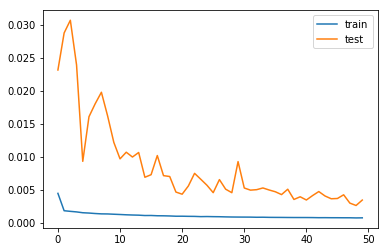

In [29]:
# plot history
plt.plot(techmodel.history['loss'], label='train')
plt.plot(techmodel.history['val_loss'], label='test')
plt.legend()
plt.show()

Perform the prediction using the test data, inverse transform the data back into its original values and calculate the mean squared errors

In [31]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.924


Obtain the plot to see how predicted data compare with expected data

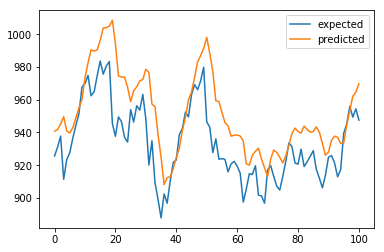

In [32]:
plt.plot(inv_y, label="expected")
plt.plot(inv_yhat, label="predicted")
plt.legend()
plt.show()

To see how predicted data differ from actual data over time

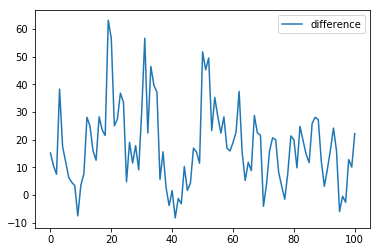

In [33]:
diff = inv_yhat-inv_y
plt.plot(diff, label='difference')
plt.legend()
plt.show()

Convert predicted y values into classifiable classes
If stock rises as predicted and stock falls as predicted then they are considered true positives and true negatives respectively.

In [34]:
predicted_y = inv_yhat[1:]
shifted_predicted_y = inv_yhat[:-1]
actual_y = inv_y[1:]
shifted_y = inv_y[:-1]

predict_diff = predicted_y - shifted_predicted_y
actual_diff = actual_y - shifted_y

predict_arr = ['up' if x >= 0 else 'down' for x in predict_diff]
actual_arr = ['up' if x >= 0 else 'down' for x in actual_diff]

Print out the confusion matrix

In [35]:
tn, fp, fn, tp = confusion_matrix(actual_arr, predict_arr, labels=['up', 'down']).ravel()
#print(confusion_matrix(actual_arr, predict_arr, labels=['up', 'down']))
print(tn, fp, fn, tp)

36 19 22 23


Accuracy score from an investor's POV

In [36]:
# focusing on minimising false positives (reducing the probability of stocks predicted that will rise but did not rise)
# hence false negatives is taken into account in the tabulation as false negatives will not be purchased as they are predicted to fall
accuracy = (tp+tn)/(tp+tn+fp+fn)
print(accuracy)

0.59
